## AutoEncoders on PointClouds - Modular Code

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.fc_ae import FullyConnectedAutoEncoder
from tf_lab.point_clouds.fc_ae import Configuration as FC_Conf

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_ae import Configuration as PN_Conf

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.in_out import train_validate_test_split
from tf_lab.point_clouds.in_out import load_crude_point_clouds

from general_tools.in_out import create_dir
from geo_tool import Point_Cloud

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
DATA_PATH = '/Users/optas/DATA/Point_Clouds/Shape_Net_Core/from_manifold_meshes/1024/03001627'
file_names = pio.load_filenames_of_input_data(DATA_PATH)
all_pclouds, model_names = load_crude_point_clouds(file_names=file_names, n_threads=10)

6778 files containing  point clouds were found.


In [11]:
train_data, val_data, test_data = train_validate_test_split(all_pclouds, train_perc=0.8, 
                                                            validate_perc=0.1, test_perc=0.1, seed=seed)

train_data = PointCloudDataSet(train_data)
val_data = PointCloudDataSet(val_data)
test_data = PointCloudDataSet(test_data)

# # train_data = PointCloudDataSet(train_data, noise={'frac':0.50, 'filler':0.0})
# # val_data = PointCloudDataSet(val_data, noise={'frac':0.50, 'filler':0.0})
# # test_data = PointCloudDataSet(test_data, noise={'frac':0.50, 'filler':0.0})

In [12]:
training_epochs = 100
batch_size = 10
saver_step = 10
train_dir = '/Users/optas/Desktop/lala'

# n_input = 1024 * 3
# conf = FC_Conf(n_input, training_epochs, batch_size=batch_size, \
#                      saver_step=saver_step, train_dir=train_dir, loss_display_step=50)
# ae = FullyConnectedAutoEncoder('fc1', conf)

n_input = [1024, 3]
conf = PN_Conf(n_input, training_epochs, batch_size=batch_size, \
                     saver_step=saver_step, train_dir=train_dir, loss_display_step=50)
ae = PointNetAutoEncoder('a4', conf)

KeyboardInterrupt: 

In [3]:
from tf_lab.models.point_net_based_AE import encoder, decoder
n_input = [1024, 3]
x = tf.placeholder(tf.float32, [None, n_input[0], n_input[1]])
y = decoder(encoder(x))


In [4]:
g = tf.get_default_graph()
# g = ae.graph

total_parameters = 0
# for variable in tf.trainable_variables():
for variable in g.get_collection('trainable_variables'):
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
#     print(shape)
#     print(len(shape))
    variable_parametes = 1
    for dim in shape:
#         print(dim)
        variable_parametes *= dim.value
#     print(variable_parametes)
    total_parameters += variable_parametes
print(total_parameters)


4133497


In [ ]:
ae.train(train_data, conf)

('Epoch:', '0001', 'loss=', '0.027149050')


In [45]:
x_sample =  x_sample[:conf.batch_size, :]
x_reconstruct, cost = ae.reconstruct(x_sample)
print cost

0.0214786


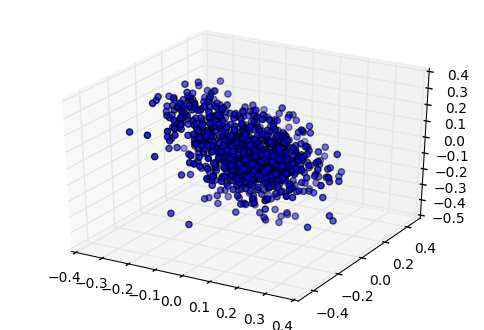

In [25]:
pclouds_samples = 1024
i = 3
Point_Cloud(points=x_reconstruct[i].reshape(pclouds_samples, 3)).plot();

# epoch = 100
# fc_ae.restore_model(osp.join(train_dir, 'model.ckpt-' + str(epoch)))


# # # saver.restore(self.session, (model_path + '-' + str(step)) if step!=None else model_path)



In [ ]:
from sklearn.cluster import KMeans
point_clouds
 sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')[source]
K-Means clustering

